In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer, seed_everything, callbacks
from lightning.pytorch.loggers import TensorBoardLogger

# Add the parent directory of NN_TopOpt to the system path
sys.path.append(os.path.abspath('..'))

from models.sdf_models import LitSdfAE, LitSdfAE_MINE
from models.sdf_models import AE, VAE, MMD_VAE
from models.sdf_models import AE_DeepSDF, VAE_DeepSDF, MMD_VAE_DeepSDF
from datasets.SDF_dataset import SdfDataset, SdfDatasetSurface, collate_fn_surface
from datasets.SDF_dataset import RadiusDataset
from datasets.SDF_dataset import ReconstructionDataset
from models.sdf_models import LitRecon_MINE


# Enable anomaly detection to help find where NaN/Inf values originate
torch.autograd.set_detect_anomaly(True)

# Enable deterministic algorithms for better debugging
# torch.use_deterministic_algorithms(True)

# # Set debug mode for floating point operations
# torch.set_printoptions(precision=10, sci_mode=False)

# # Function to check for NaN/Inf values in tensors
# def check_tensor(tensor, tensor_name=""):
#     if torch.isnan(tensor).any():
#         print(f"NaN detected in {tensor_name}")
#         print(tensor)
#         raise ValueError(f"NaN detected in {tensor_name}")
#     if torch.isinf(tensor).any():
#         print(f"Inf detected in {tensor_name}") 
#         print(tensor)
#         raise ValueError(f"Inf detected in {tensor_name}")


# Add the parent directory of NN_TopOpt to the system path
sys.path.append(os.path.abspath('..'))

root_path = '../shape_datasets'

dataset_train_files = [f'{root_path}/ellipse_reconstruction_dataset_train.csv',
                       f'{root_path}/triangle_reconstruction_dataset_train.csv',
                        f'{root_path}/quadrangle_reconstruction_dataset_train.csv',
                        ]

dataset_test_files = [f'{root_path}/ellipse_reconstruction_dataset_test.csv',
                      f'{root_path}/triangle_reconstruction_dataset_test.csv',
                      f'{root_path}/quadrangle_reconstruction_dataset_test.csv',
                 ]

train_dataset = ReconstructionDataset(dataset_train_files)
test_dataset = ReconstructionDataset(dataset_test_files)


# Create DataLoaders with shuffling
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Enable shuffling for training data
    num_workers=15
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1024,
    shuffle=True,  # No need to shuffle test data
    num_workers=15
)


print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 3000000
Test set size: 15000


In [2]:
from models.sdf_models import LitSdfAE_Reconstruction

# configs_dir = '../configs/NN_sdf_experiments/recon_MILoss'
configs_dir = '../configs/NN_sdf_experiments/model_arch_minmi'
models_dir = '../model_weights'

config_name = 'AE_DeepSDF_minMI'
# config_name = 'VAE_DeepSDF_ReconDec'
# uba_VAE_DeepSDF_minMI.pt

run_name = f'local_{config_name}_testLarge'
# saved_model_path = f'{configs_dir}/{run_name}/checkpoints/epoch=0-step=0.ckpt'
# saved_model_path = f'{models_dir}/uba_{config_name}.pt'
saved_model_path = f'{models_dir}/AE_DeepSDF_minMI_full.pt'

models = {'AE_DeepSDF': AE_DeepSDF,
          'AE': AE, 
          'VAE': VAE,
          'VAE_DeepSDF': VAE_DeepSDF,
          'MMD_VAE': MMD_VAE,
          'MMD_VAE_DeepSDF': MMD_VAE_DeepSDF}

In [3]:
# from lightning.pytorch.callbacks import Callback
torch.autograd.set_detect_anomaly(True)
import yaml

MAX_EPOCHS = 1
MAX_STEPS = MAX_EPOCHS * len(train_loader)

# Training setup
trainer = Trainer(
    max_epochs=MAX_EPOCHS, # the first epoch for training all model, the second one for training rec decoder
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(
        name='AE_MI_ReconDec', 
        save_dir='../logs', 
        default_hp_metric=False, 
        version=run_name
    ),
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_reconstruction_loss',
            mode='min',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_reconstruction_loss:.2f}'
        ),
        callbacks.EarlyStopping(
            monitor='val_reconstruction_loss',
            patience=10,
            mode='min'
        ) #,
        # FirstEvalCallback()
    ],
    check_val_every_n_epoch=None,  # Disable validation every epoch
    val_check_interval=5000  # Perform validation every 2000 training steps
)

# Load configuration from YAML file
with open(f'{configs_dir}/{config_name}.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Initialize VAE model
model_params = config['model']['params']
model_params['input_dim'] = 17 # train_dataset.feature_dim
vae_model = models[config['model']['type']](**model_params)

# Load pre-trained weights for the model
# pretrained_weights_path = config['model']['pretrained_weights_path'
state_dict = torch.load(saved_model_path)
# new_state_dict = vae_model.state_dict()

# # Update the new_state_dict with the loaded state_dict, ignoring size mismatches
# for key in state_dict:
#     if key in new_state_dict and state_dict[key].size() == new_state_dict[key].size():
#         new_state_dict[key] = state_dict[key]

vae_model.load_state_dict(state_dict)

"""
# Initialize VAE trainer
trainer_params = config['trainer']['params']
trainer_params['vae_model'] = vae_model
trainer_params['max_steps'] = MAX_STEPS
# vae_trainer = LitRecon_MINE(**trainer_params)
vae_trainer = LitSdfAE_Reconstruction(**trainer_params)

# Train the model
trainer.validate(vae_trainer, dataloaders=test_loader)
# trainer.fit(vae_trainer,  train_dataloaders=[train_loader, train_loader], val_dataloaders=[test_loader, surface_test_loader, radius_samples_loader])
"""

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


regularization: l2, reg_weight: 0.1
Using orthogonality loss: None


/tmp/ipykernel_25505/3242846145.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(saved_model_path)


"\n# Initialize VAE trainer\ntrainer_params = config['trainer']['params']\ntrainer_params['vae_model'] = vae_model\ntrainer_params['max_steps'] = MAX_STEPS\n# vae_trainer = LitRecon_MINE(**trainer_params)\nvae_trainer = LitSdfAE_Reconstruction(**trainer_params)\n\n# Train the model\ntrainer.validate(vae_trainer, dataloaders=test_loader)\n# trainer.fit(vae_trainer,  train_dataloaders=[train_loader, train_loader], val_dataloaders=[test_loader, surface_test_loader, radius_samples_loader])\n"

In [6]:
trainer.fit(vae_trainer, train_loader, val_dataloaders=test_loader)
trainer.validate(vae_trainer, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | vae  | AE_DeepSDF | 2.5 M  | train
--------------------------------------------
334 K     Trainable params
2.2 M     Non-trainable params
2.5 M     Total params
10.068    Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Epoch 0:   2%|▏         | 1019/46875 [00:09<06:52, 111.08it/s, v_num=arge, train_reconstruction_loss=0.0105]

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0: 100%|██████████| 46875/46875 [06:42<00:00, 116.45it/s, v_num=arge, train_reconstruction_loss=0.00076, val_reconstruction_loss=0.000784] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 46875/46875 [06:42<00:00, 116.45it/s, v_num=arge, train_reconstruction_loss=0.00076, val_reconstruction_loss=0.000784]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 241.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val_reconstruction_loss  │   0.0006551854312419891   │
└───────────────────────────┴───────────────────────────┘

[{'val_reconstruction_loss': 0.0006551854312419891}]

In [7]:
# Save model weights
checkpoint_path = f'../model_weights/{config_name}_full.ckpt'
trainer.save_checkpoint(checkpoint_path)
print(f"Model weights saved to {checkpoint_path}")

# Save just the model weights
model_weights_path = f'../model_weights/{config_name}_full.pt'
torch.save(vae_model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

Model weights saved to ../model_weights/AE_DeepSDF_minMI_full.ckpt
Model weights saved to ../model_weights/AE_DeepSDF_minMI_full.pt


In [5]:
# Get a batch from test dataset
test_batch = next(iter(test_loader))
x, sdf, tau = test_batch

# Get reconstruction
with torch.no_grad():
    output = vae_trainer.vae(x, reconstruction=True)
    x_reconstructed = output["x_reconstructed"]

# Convert to numpy for printing
x_original = x[:, 2:].cpu().numpy()  # Remove first two columns (query points)
x_recon = x_reconstructed.cpu().numpy()

# Print first example
print("Original input:")
print(x_original[0])
print("\nReconstructed input:")
print(x_recon[0])

print("\nMean squared error:")
print(np.mean((x_original[0] - x_recon[0])**2))



Original input:
[ 1.          0.          0.          0.          0.          0.
  0.          0.28765425  0.00435199 -0.13672063  0.5061471   0.08268851
  0.25812495  0.03979816  0.03468505]

Reconstructed input:
[ 0.97377163 -0.00127479 -0.01857942  0.04737308 -0.0012825   0.01641689
  0.00858827  0.1657464   0.19075702 -0.16050619  0.40969667  0.05024543
  0.24961865  0.06574667  0.05172922]

Mean squared error:
0.0043459604


In [6]:
mse_list = []
mse_loss_list = []

min_x_orignal_list = []
max_x_orignal_list = []

from tqdm import tqdm

for batch in tqdm(test_loader, desc="Processing batches"):
    x, sdf, tau = batch
    with torch.no_grad():
        output = vae_trainer.vae(x, reconstruction=True)
        x_reconstructed = output["x_reconstructed"]
    # mse_list.append(np.mean((x_original[0] - x_recon[0])**2))

    reconstruction_loss = F.mse_loss(x_reconstructed, x[:, 2:])
    mse_loss_list.append(reconstruction_loss.item())

    x_original = x[:, 2:].cpu().numpy()  # Remove first two columns (query points)
    x_recon = x_reconstructed.cpu().numpy()

    min_x_orignal_list.append(np.min(x_original, axis=0))
    max_x_orignal_list.append(np.max(x_original, axis=0))

    for i in range(x.shape[0]):
        mse_list.append(np.mean((x_original[i] - x_recon[i])**2))
        if np.mean((x_original[i] - x_recon[i])**2) > 1:
            print(x_original[i])
            print(x_recon[i])
            print('##########################')

print(np.mean(mse_list))


Processing batches: 100%|██████████| 15/15 [00:01<00:00, 10.85it/s]

0.0005753335


In [7]:
min_x_orignal_list = np.array(min_x_orignal_list)
max_x_orignal_list = np.array(max_x_orignal_list)

print(np.min(min_x_orignal_list, axis=0))
print(np.max(max_x_orignal_list, axis=0))


[ 0.          0.         -0.7999071   0.          0.          0.
  0.         -0.7465448  -0.19996221 -0.7996888   0.          0.
  0.          0.          0.        ]
[1.         0.9999004  0.79975617 0.7998178  0.28669968 0.13952504
 0.27289107 0.7998604  0.79947066 0.7998327  0.7998623  0.27184445
 0.9995778  0.9305225  0.2528884 ]


In [27]:
def stat_for_jumps(model, dataloader, num_samples=4000, n_samples=50):
    """Visualize the latent space"""
    model.eval()
    latent_vectors = []
    chis = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches"):
            output = model(batch[0])
            # print(output)
            latent_vectors.append(output["z"])
            chis.append(batch[0][:, 2:])
            sdf.append(output["sdf_pred"])
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            # if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                # break
                
    latent_vectors = torch.cat(latent_vectors, dim=0) #[:num_samples]
    chis = torch.cat(chis, dim=0) #[:num_samples]
    labels = chis[:, 0]
    non_ellipse_indices = labels != 0
    non_ellipse_labels = labels[non_ellipse_indices]
    # print(non_ellipse_labels)
    latent_vectors = latent_vectors[non_ellipse_indices] #.cpu().numpy()
    normalized_ratios = torch.linspace(0.5, 1.5, n_samples)/1.5

    # print(chis[labels==0])

    ellipses_X = torch.zeros((n_samples, chis.shape[1]+2))
    ellipses_X[:, 3] = normalized_ratios

    # print(ellipses_X)

    with torch.no_grad():
        output = model(ellipses_X)
        ellipses_latent_vectors = output["z"]

    from sklearn.metrics.pairwise import euclidean_distances

    closest_latent_vectors = []
    closest_labels = []

    for ellipse_latent in tqdm(ellipses_latent_vectors, desc="Processing ellipses"):
        distances = euclidean_distances(latent_vectors.cpu().numpy(), ellipse_latent.cpu().numpy().reshape(1, -1))
        closest_index = np.argmin(distances)
        closest_latent_vectors.append(latent_vectors[closest_index])
        closest_labels.append(non_ellipse_labels[closest_index])

    closest_latent_vectors = torch.stack(closest_latent_vectors)
    closest_labels = torch.stack(closest_labels)


    unique_closest_latent_vectors = torch.unique(closest_latent_vectors, dim=0)
    print(f"Number of unique closest_latent_vectors: {unique_closest_latent_vectors.shape[0]}")

    return closest_latent_vectors.cpu().numpy(), latent_vectors.cpu().numpy()

closest_latent_vectors, latent_vectors = stat_for_jumps(vae_model, test_loader)

stats_dir=f'../z_limits'
if stats_dir is not None and config_name is not None:
    np.savez(
        f"{stats_dir}/{config_name}_jump_stats.npz",
        closest_latent_vectors=closest_latent_vectors,
        latent_vectors=latent_vectors
    )


Processing ellipses: 100%|██████████| 50/50 [00:00<00:00, 609.87it/s]

Number of unique closest_latent_vectors: 9


In [29]:
1.73*0.5 - 0.5

0.365

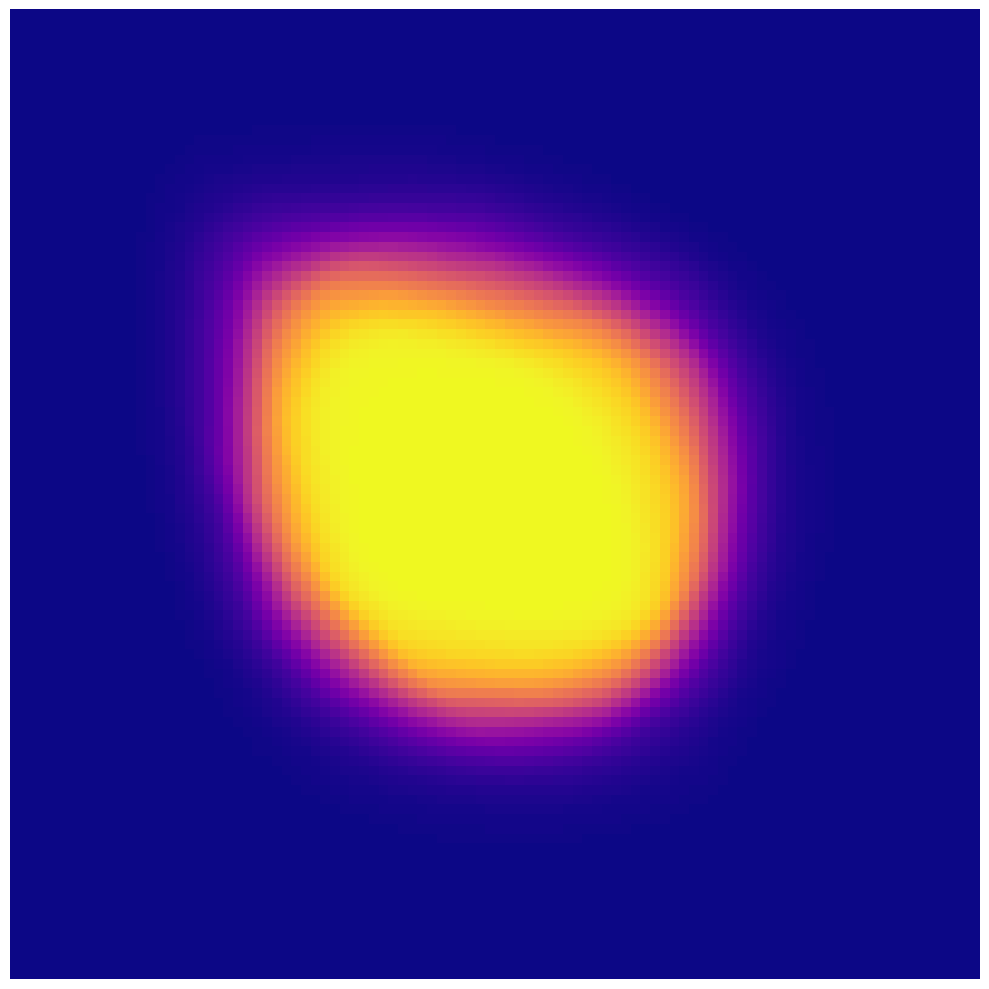

In [6]:
from vizualization_utils import plot_predicted_sdf, get_latent_subspaces, plot_sdf_surface

test_traingle_chi = torch.zeros(2, 17)
# test_traingle_chi[:, 2] = 0.5
# test_traingle_chi[:, 4] = 0
# test_traingle_chi[:, 5] = 0.365
# test_traingle_chi[:, 6] = 0.25/3
# test_traingle_chi[:, 7] = 0.25/3
# test_traingle_chi[:, 8] = 0.25/3

R = 0.45/3

test_traingle_chi[:, 2] = 1
test_traingle_chi[:, 9] = 0.5
test_traingle_chi[:, 10] = 0.5
test_traingle_chi[:, 11] = -0.5
test_traingle_chi[:, 12] = 0.5
test_traingle_chi[:, 13] = R
test_traingle_chi[:, 14] = R
test_traingle_chi[:, 15] = R
test_traingle_chi[:, 16] = R


vae_model.eval()
with torch.no_grad():
    output = vae_model(test_traingle_chi)
    triangle_latent_vectors = output["z"]

plot_sdf_surface(vae_model, triangle_latent_vectors[0], countur=False, filename=None)

# for i in range(50):
#     plot_sdf_surface(vae_model, closest_latent_vectors[i], countur=False, filename=None)

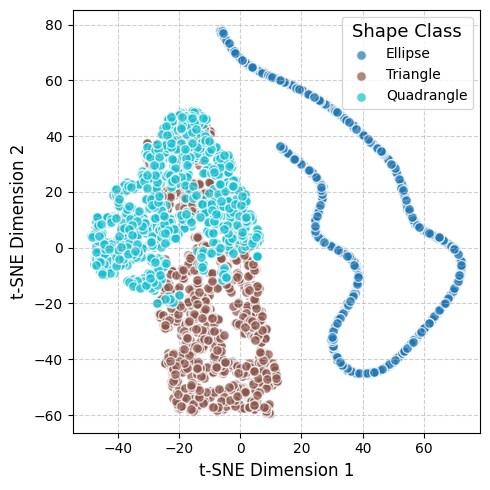

In [4]:
from vizualization_utils import plot_latent_space, plot_latent_space_radius_sum


# filename = '../paper/icml2025/latex_figures/frst_strg.png'
filename = None
plot_latent_space(vae_model, test_loader, filename=filename)

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/vizualization_utils.py:400: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


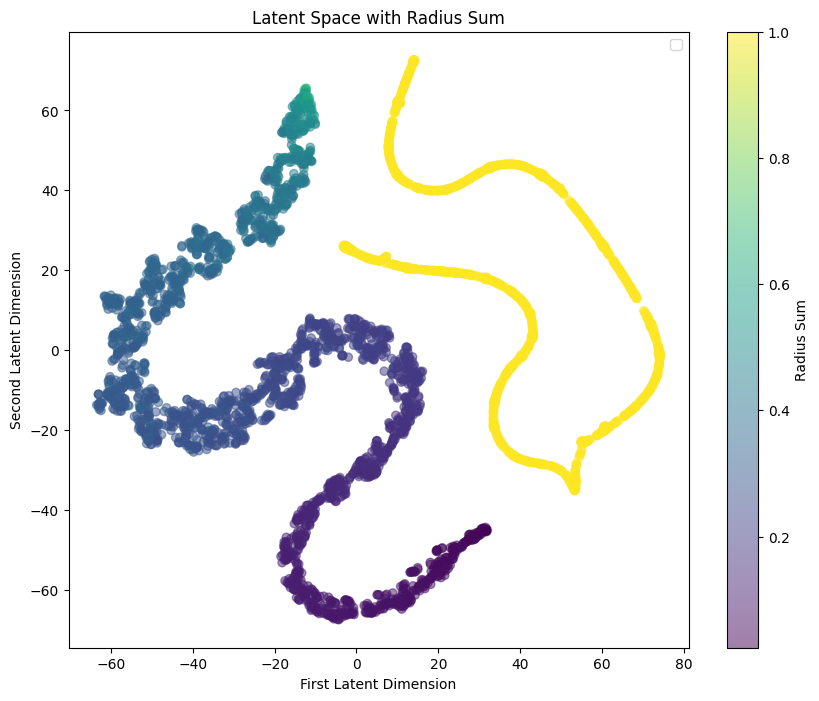

In [11]:
plot_latent_space_radius_sum(vae_model, test_loader, filename=None, latent_dim=3)

<Figure size 1500x500 with 0 Axes>

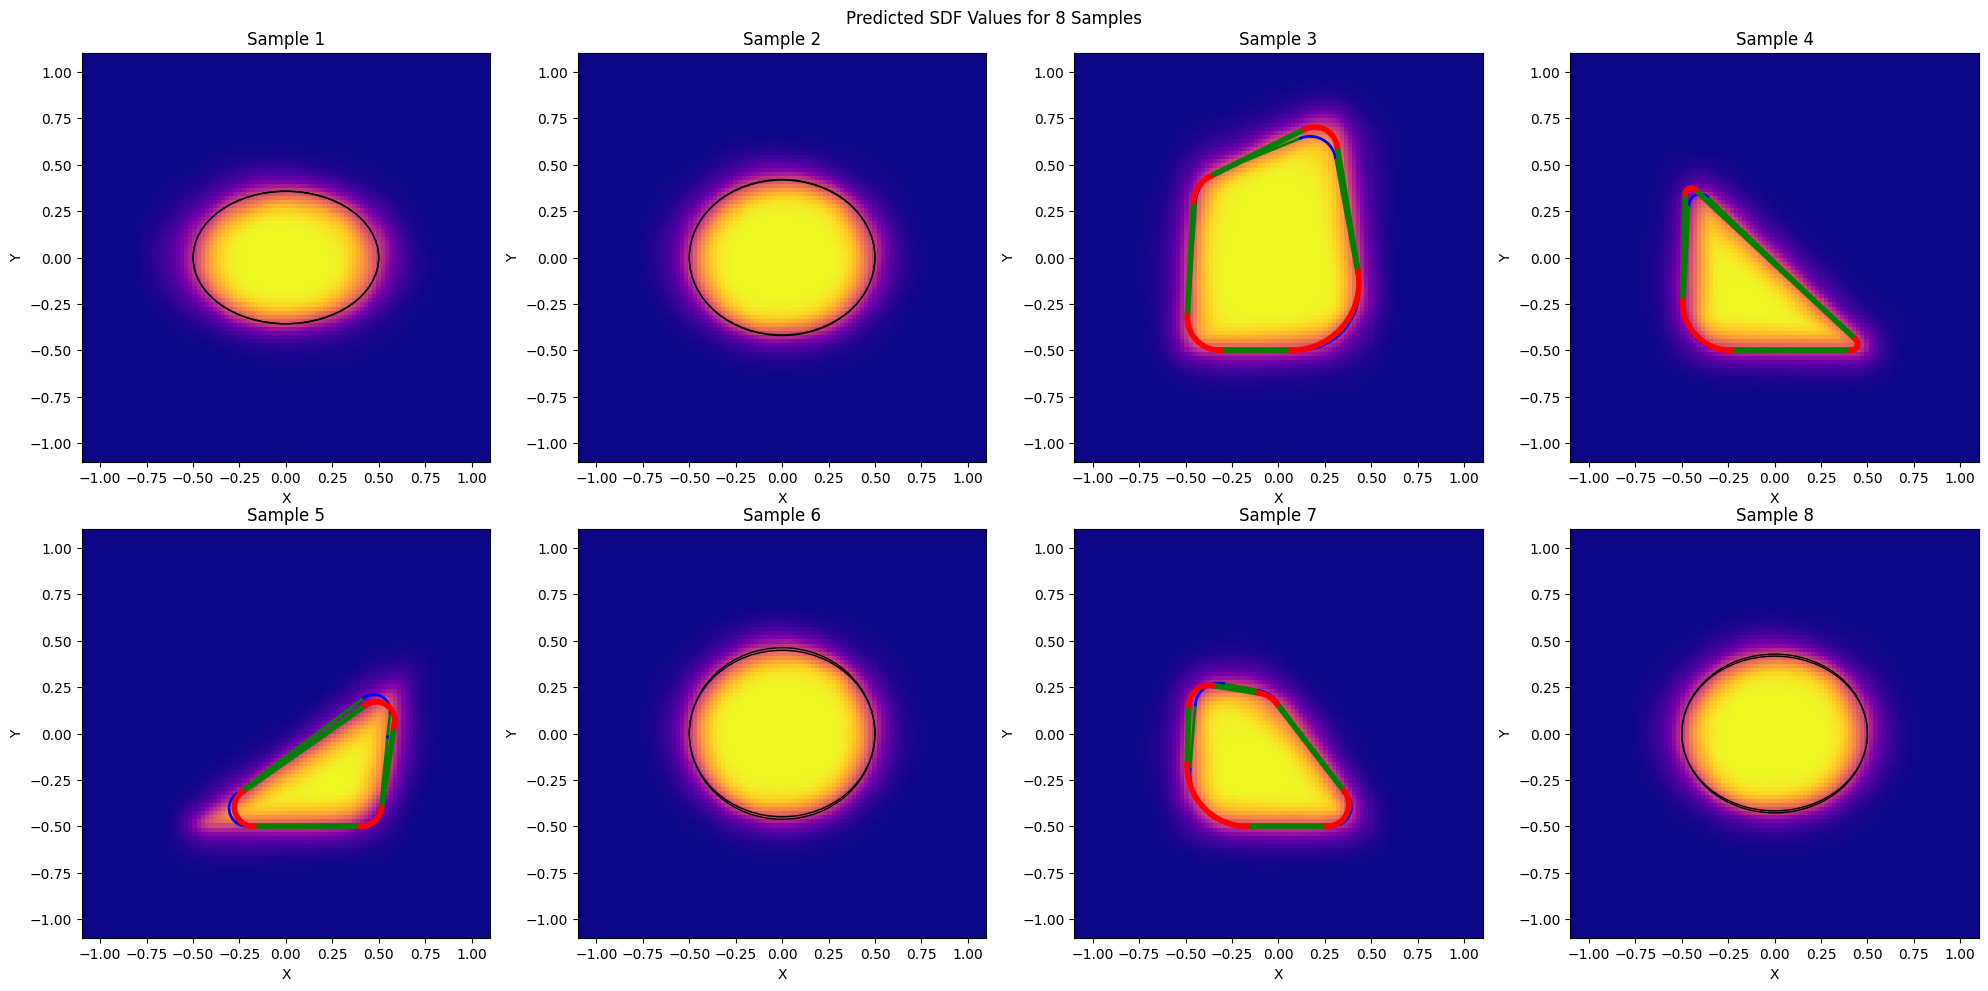

In [14]:
# sys.path.append(os.path.abspath('../NN_TopOpt/mesh_utils'))

# from mesh_utils import extract_geometry


plot_predicted_sdf(vae_model, test_loader)

In [15]:
triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors = get_latent_subspaces(vae_model, test_loader)

print(triangle_latent_vectors.shape)
print(quadrangle_latent_vectors.shape)
print(ellipse_latent_vectors.shape)


torch.Size([5000, 9])
torch.Size([5000, 9])
torch.Size([5000, 9])


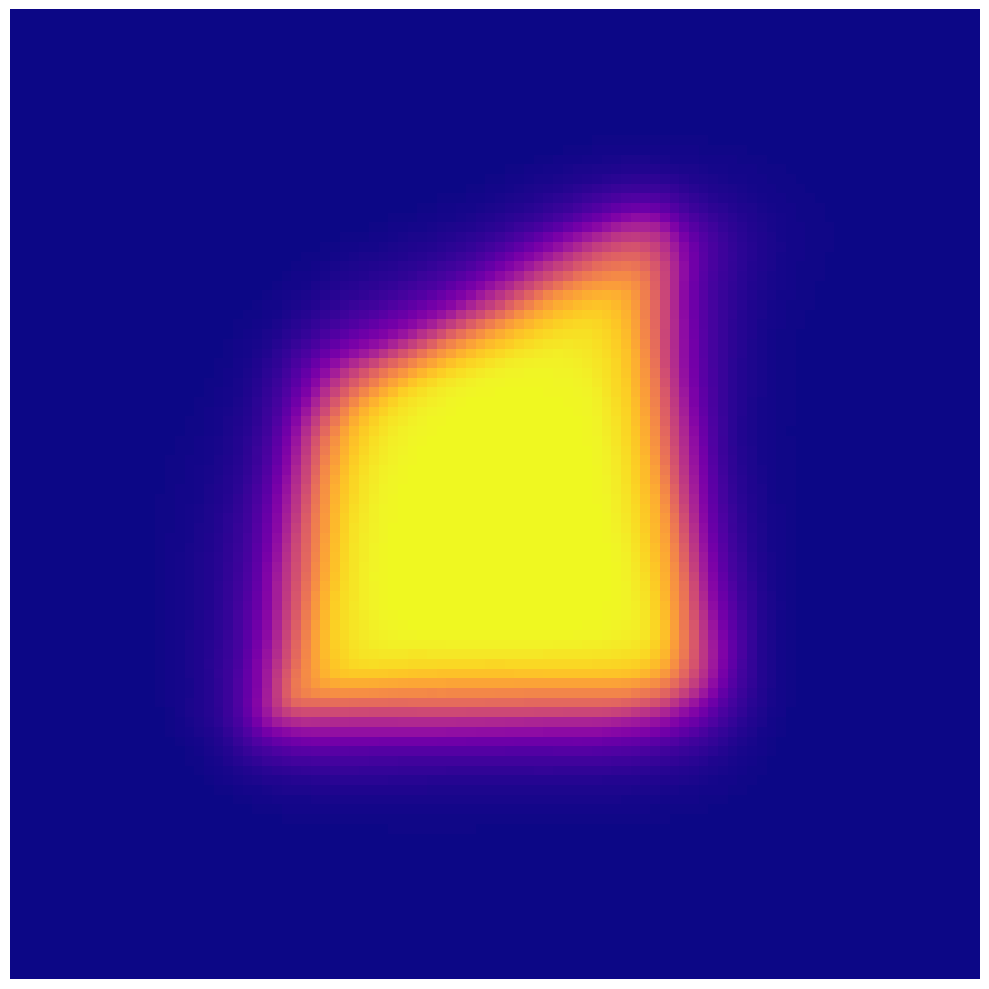

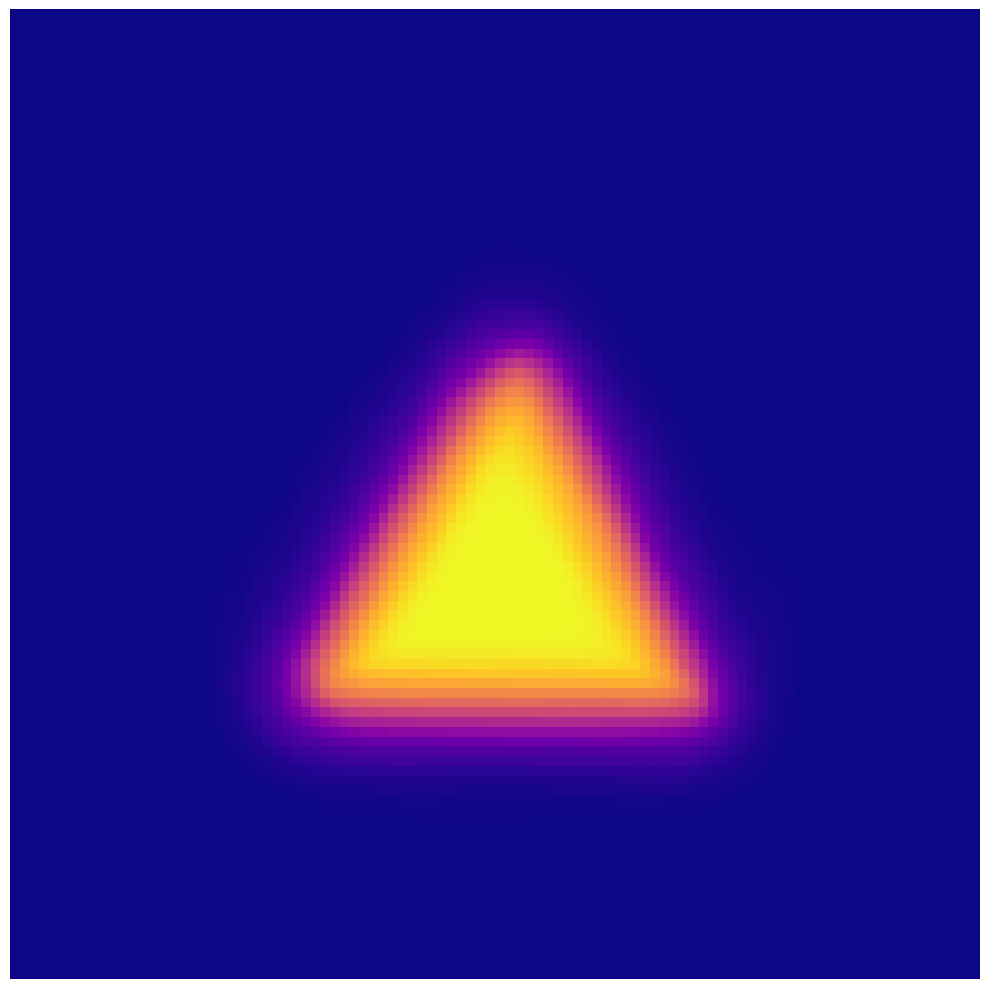

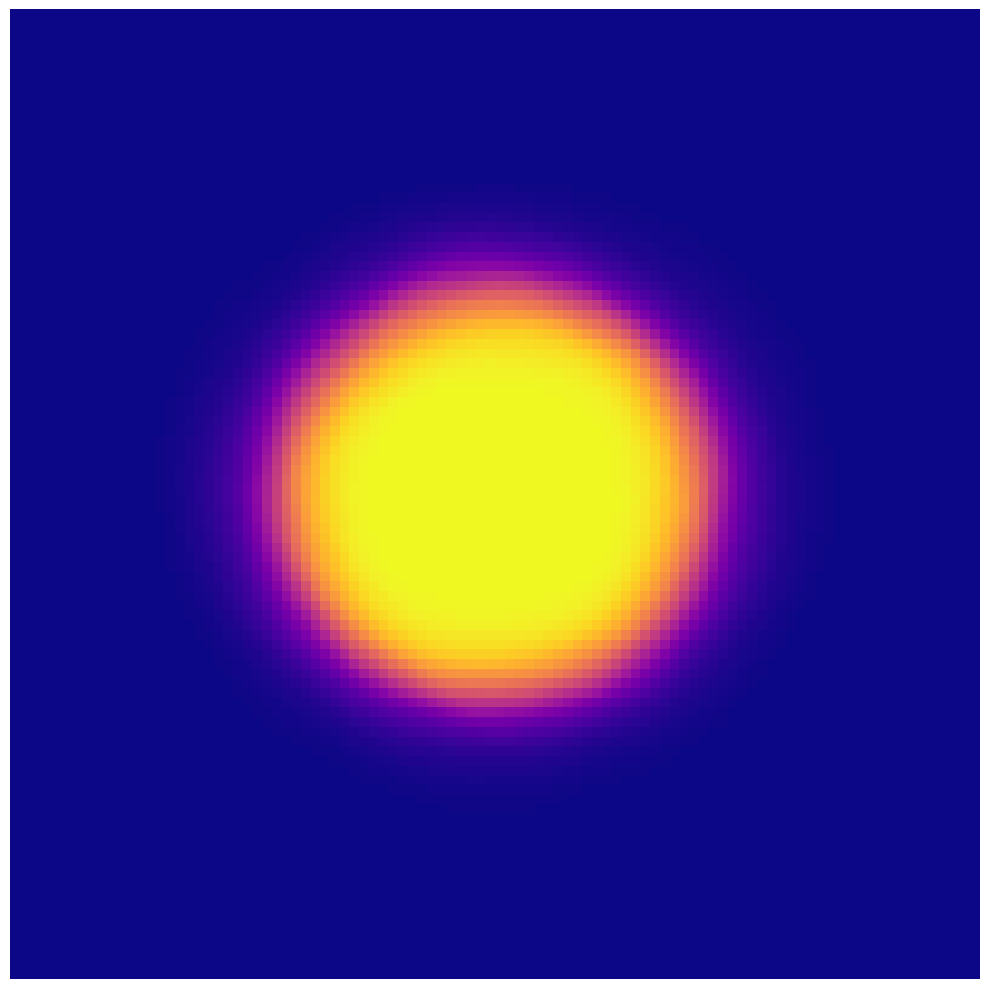

In [17]:
quadrangle_index = 6 #3 4
triangle_index = 0
ellipse_index = 4

z_triangle = triangle_latent_vectors[triangle_index]
z_quadrangle = quadrangle_latent_vectors[quadrangle_index]
z_ellipse = ellipse_latent_vectors[ellipse_index]

plot_sdf_surface(vae_model, z_quadrangle, countur=False, filename=None)
plot_sdf_surface(vae_model, z_triangle, countur=False, filename=None)
plot_sdf_surface(vae_model, z_ellipse, countur=False, filename=None)

/tmp/ipykernel_7056/3576873513.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z1 = torch.tensor(z1, dtype=torch.float32)
/tmp/ipykernel_7056/3576873513.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z2 = torch.tensor(z2, dtype=torch.float32)
/tmp/ipykernel_7056/3576873513.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z3 = torch.tensor(z3, dtype=torch.float32)


torch.Size([21, 9])


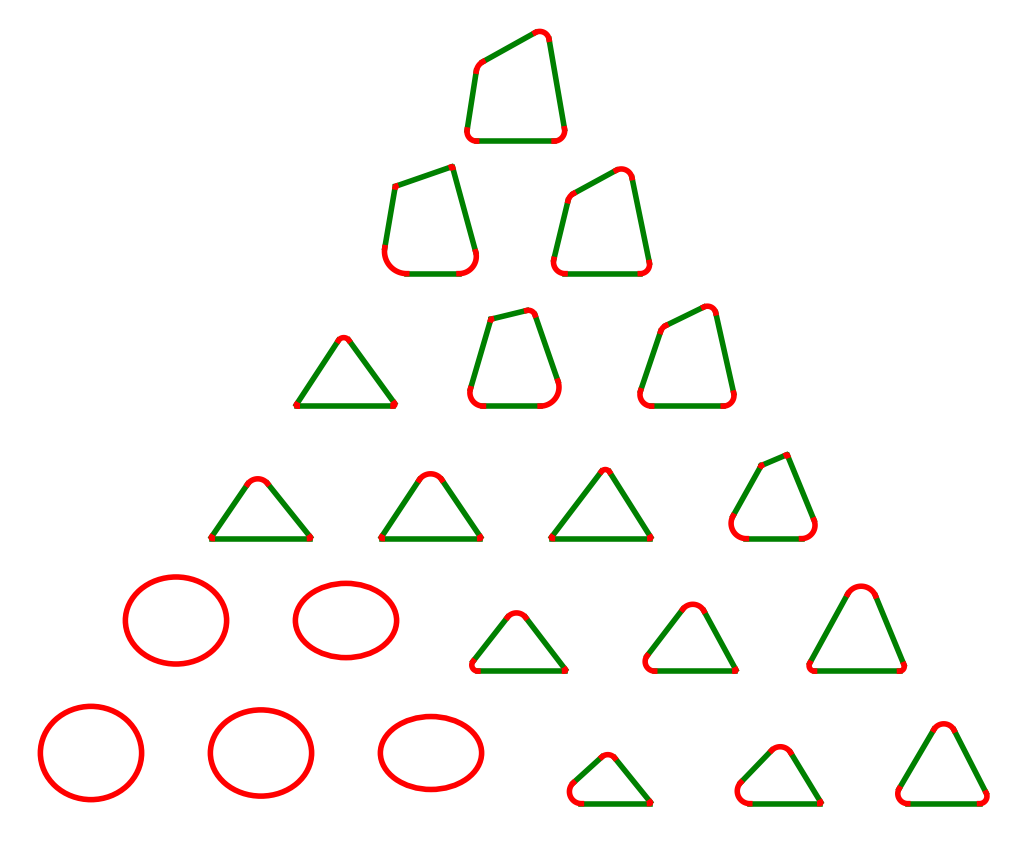

In [18]:
# from vizualization_utils import plot_sdf_transition_triangle
from vizualization_utils import extract_geometry #, #draw_geometry, plot_curve
from matplotlib.patches import Ellipse, Polygon


def plot_curve(grid_points, sdf_pred, ax):

    # ax.set_xlim(-0.9, 0.9)
    # ax.set_ylim(-0.9, 0.9)

    curve_mask = torch.logical_and(sdf_pred[:, 0] > 0.4, sdf_pred[:, 0] < 0.6)
    curve_mask_reshaped = curve_mask.reshape(100, 100)[13:87, 13:87]
    ax.imshow(curve_mask_reshaped, cmap='gray_r', origin='lower')
    return ax

def draw_geometry(geometry_type, geometry_params, ax):

    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.8, 0.8)
    
    if geometry_type == "ellipse":
        a = geometry_params[1]
        b = geometry_params[2]
        ellipse = Ellipse(np.array([0, 0]), 2*a, 2*b, fill=False, color='red', linewidth=4)
        ax.add_patch(ellipse)

    elif geometry_type == "polygon":
        vertices = geometry_params[0]
        radiuses = geometry_params[1]
        line_segments = geometry_params[2]
        arc_segments = geometry_params[3]
        # axs[row, col].add_patch(Polygon(vertices, fill=False, color='green', linewidth=4))
        # Plot line segments
        for start, end in line_segments:
            ax.plot([start[0], end[0]], [start[1], end[1]], 'g-', linewidth=4)
            # ax2.plot([start[0], end[0]], [start[1], end[1]], [z_offset, z_offset], 'g-', linewidth=line_width)

        # Plot arc segments
        for center, start_angle, end_angle, radius in arc_segments:
            # Calculate angles for arc
            
            # Ensure we draw the shorter arc
            if abs(end_angle - start_angle) > np.pi:
                if end_angle > start_angle:
                    start_angle += 2*np.pi
                else:
                    end_angle += 2*np.pi
                    
            # Create points along arc
            theta = np.linspace(start_angle, end_angle, 100)
            x = center[0] + radius * np.cos(theta)
            y = center[1] + radius * np.sin(theta)
            ax.plot(x, y, 'r-', linewidth=4)

def plot_sdf_transition_triangle(model, z1, z2, z3, num_steps=10, filename=None, plot_geometry=False):
    """
    Plots the transition of SDF maps between three latent vectors in a triangular format.
    
    Parameters:
    - model: The VAE model
    - z1: The first latent vector
    - z2: The second latent vector
    - z3: The third latent vector
    - num_steps: Number of steps in the transition
    """
    z1 = torch.tensor(z1, dtype=torch.float32)
    z2 = torch.tensor(z2, dtype=torch.float32)
    z3 = torch.tensor(z3, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = []
    for i in range(num_steps):
        for j in range(num_steps - i):
            z = z1 * (i / (num_steps - 1)) + z2 * (j / (num_steps - 1)) + z3 * ((num_steps - 1 - i - j) / (num_steps - 1))
            z_steps.append(z)

    # z_batch = torch.tensor(z_steps).to(model.device)
    z_batch = torch.stack(z_steps)
    print(z_batch.shape)
    chis = model.decoder_input(z_batch).detach().cpu().numpy()
    
    x = np.linspace(-1.0, 1.0, 100)
    y = np.linspace(-1.0, 1.0, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(10, 9))
    # fig.suptitle('SDF Transition Between Shapes in Triangle Format', fontsize=16, fontweight='bold')

    scale = 0.85 / (num_steps - 1)
    
    with torch.no_grad():
        idx = 0
        for i in range(num_steps):
            for j in range(num_steps - i):
                z = z_steps[idx]
                # Calculate the position for each icon
                x_pos = (i + 0.5 * j) * scale
                y_pos = (np.sqrt(3) / 2 * j) * scale
                
                # Plot each SDF as an icon at the calculated position
                if plot_geometry:
                    ax_inset = fig.add_axes([x_pos, y_pos, 0.18, 0.18])
                    chi_pred = chis[idx]
                    geometry_type, geometry_params = extract_geometry(chi_pred)
                    draw_geometry(geometry_type, geometry_params, ax_inset)
                else:
                    ax_inset = fig.add_axes([x_pos, y_pos, 0.16, 0.16])   
                    sdf_pred = model.sdf(z, grid_points)
                    sdf_grid = sdf_pred.reshape(X.shape)
                    plot_curve(grid_points, sdf_pred, ax_inset)

                ax_inset.set_aspect('equal')
                ax_inset.set_frame_on(False)
                ax_inset.set_xticks([])
                ax_inset.set_yticks([])
                # ax_inset.set_title(f'Step {idx+1}', fontsize=10)
                idx += 1

    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05)
    # plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

# filename = '../paper/icml2025/latex_figures/reconstruction_geometry.png'
filename = None
plot_sdf_transition_triangle(vae_model, z_triangle, z_quadrangle, z_ellipse, num_steps=6, filename=filename, plot_geometry=True)

/tmp/ipykernel_7056/3576873513.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z1 = torch.tensor(z1, dtype=torch.float32)
/tmp/ipykernel_7056/3576873513.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z2 = torch.tensor(z2, dtype=torch.float32)
/tmp/ipykernel_7056/3576873513.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z3 = torch.tensor(z3, dtype=torch.float32)


torch.Size([21, 9])


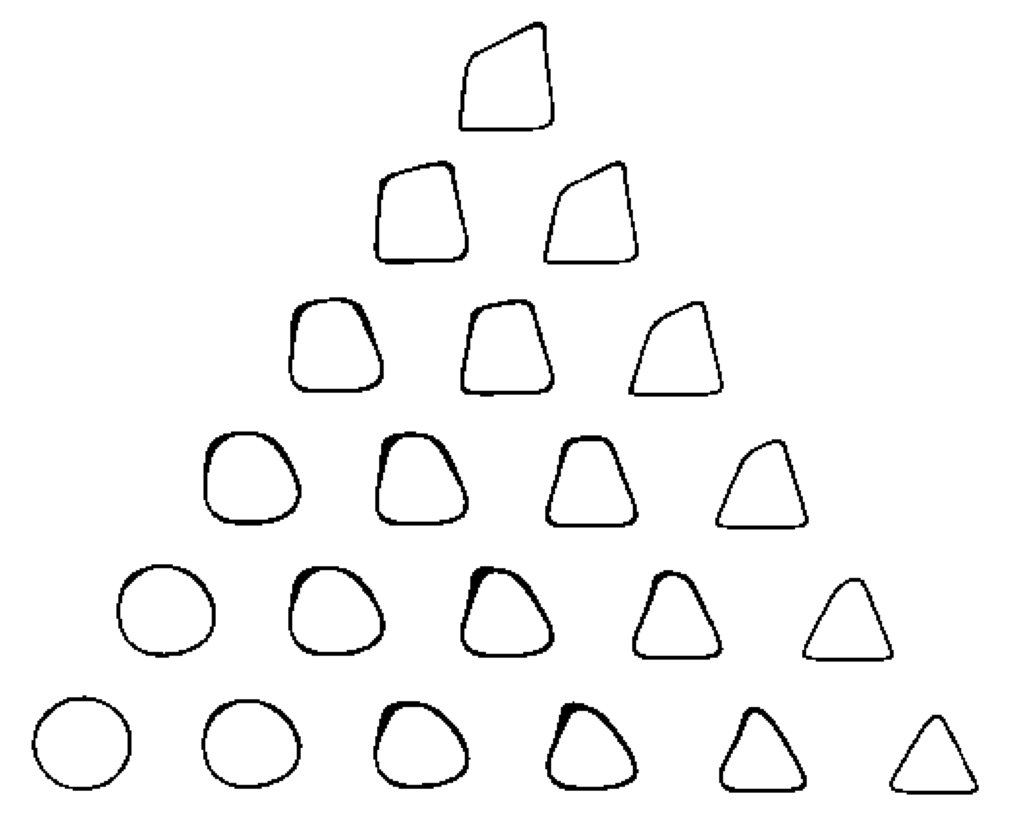

In [19]:

# filename = '../paper/icml2025/latex_figures/reconstruction_Hv_border.png'
filename = None
plot_sdf_transition_triangle(vae_model, z_triangle, z_quadrangle, z_ellipse, num_steps=6, filename=filename, plot_geometry=False)
